In [1]:
import os
import glob
import copy
import yaml
import matplotlib.pyplot as plt
import matplotlib
from lib import feature_extraction as fe, models
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.inspection import permutation_importance
import  numpy as np
import pandas as pd 
from collections import Counter

font = {
    "family": "sans-serif",
    "weight": "bold",
    "size": 12
}
matplotlib.rc("font", **font)

# Figures save paths
with open("secrets.yml", "r") as file_handle:
    fig_save_paths = yaml.load(file_handle, Loader=yaml.Loader)

# Data Loader

- Selecting and loading the required data instances
- Loading all data from the LiftingAssessment Task

In [2]:
# Main data path
data_path = os.path.join(os.getcwd(), "data")
# Selecting Task-2
weight_lifting = os.path.join(data_path, "LiftingAssessment")
# Get all the ".csv" files
all_parsed_files = glob.glob("**/*.csv", root_dir=weight_lifting, recursive=True)

# Load the data
loaded_data = {}
for file_path in all_parsed_files:
    # Full path to file
    full_path = os.path.join(weight_lifting, file_path)

    # Load the time of DAQ
    with open(full_path, "r") as file_handle:
        daq_time = file_handle.readline()
        daq_time = daq_time.split(" ")[-1]
        daq_time = int(daq_time[0:-2])
    # Read the csv
    df = pd.read_csv(full_path, header="infer", skiprows=1)

    # Store data
    loaded_data[full_path] = {
        "daq_time": daq_time,
        "df": df
    }


In [3]:
# Print the counts
print(f"Total number of files loaded - {len(loaded_data.keys())}")

Total number of files loaded - 1080


In [4]:
# Group by features
box_types = ["Crate", "CardboardBox"]
weight_levels = ["W2", "W5", "W10", "W15", "W20", "W30"]
labelled_data = {}
for box_instance in box_types:
    for weight_instance in weight_levels:
        labelled_data[box_instance + "-" + weight_instance] = []

for file_id in loaded_data.keys():
    box_instance = file_id.split(os.sep)[-4]
    weight_instance = file_id.split(os.sep)[-3]
    labelled_data[box_instance + "-" + weight_instance].append(file_id)
    

In [5]:
# Print number of items within each group
for class_instance in labelled_data.keys():
    print(f"For the class - {class_instance}, total number of items are {len(labelled_data[class_instance])}")

For the class - Crate-W2, total number of items are 90
For the class - Crate-W5, total number of items are 90
For the class - Crate-W10, total number of items are 90
For the class - Crate-W15, total number of items are 90
For the class - Crate-W20, total number of items are 90
For the class - Crate-W30, total number of items are 90
For the class - CardboardBox-W2, total number of items are 90
For the class - CardboardBox-W5, total number of items are 90
For the class - CardboardBox-W10, total number of items are 90
For the class - CardboardBox-W15, total number of items are 90
For the class - CardboardBox-W20, total number of items are 90
For the class - CardboardBox-W30, total number of items are 90


In [6]:
sentinels_samplingRate = {"DAQSentinel01": [],
                          "DAQSentinel02": [],
                          "DAQSentinel03": []}
sampling_rates = {}
for file_path, data in loaded_data.items():
    # Choose the right sentinel
    sentinel = file_path.split("/")[-1].split("_")[0]

    # Determine sampling rate
    total_time = data["daq_time"]
    samples = data["df"].shape[0]
    sentinels_samplingRate[sentinel].append(samples / total_time)

for sentinel in sentinels_samplingRate.keys():
    print("Sampling Rate for " + sentinel + " with mean " + str(round(np.mean(sentinels_samplingRate[sentinel]), 2)) +
          " and std of " + str(round(np.std(sentinels_samplingRate[sentinel]), 2)))

    # Get the mean sampling rate
    sampling_rates[sentinel] = round(np.mean(sentinels_samplingRate[sentinel]), 2)

Sampling Rate for DAQSentinel01 with mean 396.65 and std of 14.48
Sampling Rate for DAQSentinel02 with mean 387.91 and std of 14.11
Sampling Rate for DAQSentinel03 with mean 390.2 and std of 14.17


In [7]:
class_combined_dfs = {}
num_individuals_analyzed  = 3
sentinels = ["DAQSentinel01", "DAQSentinel02", "DAQSentinel03"]

# Group dataframes together
for class_instance in labelled_data.keys():
    # Differentiate by Sentinels
    class_combined_dfs[class_instance] = {}
    
    # Sentinels data instance counters
    counters = {}
    
    # Go through each file
    for file_id in labelled_data[class_instance]:
        # Get the sentinel name
        sentinel = file_id.split(os.sep)[-1].split("_")[0]
        
        # Get the dataframe
        df = loaded_data[file_id]["df"].copy(deep=True)
        # Remove the starting and ending data instances
        df = df.iloc[int(4 * sampling_rates[sentinel]):int(df.shape[0] - (4 * sampling_rates[sentinel]))]
        
        if sentinel in list(class_combined_dfs[class_instance].keys()):
            class_combined_dfs[class_instance][sentinel] = pd.concat([class_combined_dfs[class_instance][sentinel], df], ignore_index=True, copy=True)
            counters[sentinel] += 1
        else:
            class_combined_dfs[class_instance][sentinel] = df
            counters[sentinel] = 1
            
    # Assert at the end of every class
    for s in counters.values():
        assert s == 10 * num_individuals_analyzed, "Each sentinel should add upto 20 counts for two individuals"


# Segmentation

- 1 second segments with 250ms overlap between segments

In [8]:
# To ensure order
data_cols_considered = ["acc-X", "acc-Y", "acc-Z", "gyr-X", "gyr-Y", "gyr-Z"]

In [9]:
def segment_data(data_array: np.array, segment_window: float, overlap: float, sampling_rate: float):
    
    window_size = int(segment_window * sampling_rate)
    starting_points = np.arange(0, data_array.shape[0], int(window_size * (1 - overlap))).astype("uint32")
    
    data_segments = list()
    for starting_index in starting_points:
        if(starting_index + window_size) < data_array.shape[0]:
            data_segments.append(
                data_array[starting_index:starting_index + window_size, ...])
            
    return np.array(data_segments)
    

In [10]:
# Segment the data
sentinel_segmented_data = {}
for class_instance in class_combined_dfs.keys():
    sentinel_segmented_data[class_instance] = {}
    for sentinel in class_combined_dfs[class_instance].keys():
        sentinel_segmented_data[class_instance][sentinel] = segment_data(class_combined_dfs[class_instance][sentinel][data_cols_considered].to_numpy(), 1.0, 0.75, sampling_rates[sentinel])


# Feature Extraction

Extraction key features from the sensor data. Consider time domain, frequency domain, and time-frequency domain features

Extracting the following features, a total of 17 features

1. Time Domain Features - 11
2. Frequency Domain Features - 3
3. Time-frequency Domain Features - 3

In [11]:
features_extracted_data = {}
for class_instance in sentinel_segmented_data.keys():
    features_extracted_data[class_instance] = {}
    for sentinel in sentinel_segmented_data[class_instance].keys():
        data = sentinel_segmented_data[class_instance][sentinel]
        
        # Select arguments based on sentinel
        freq_args = [{"axis": 0}, {"axis": 0}, {"axis": 0, "nperseg": 200, "noverlap": 100, "fs": sampling_rates[sentinel]}]
        freq_time_args = [{"wavelet": "db1"}, {"wavelet": "db1"}, {"wavelet": "db1"}]
        
        # Apply transformation to every data row
        for index, row in enumerate(data):
            computed_segments_sensors = []
            for i in range(data.shape[-1]):
                # apply the transformation
                computed_segments_sensors += fe.compute_all_features(row[:, i], freq_args=freq_args, freq_time_args=freq_time_args)
            
            data_array = np.array(computed_segments_sensors).T
            if index == 0:
                features_extracted_data[class_instance][sentinel] = copy.deepcopy(data_array[np.newaxis, ...])
            else:
                features_extracted_data[class_instance][sentinel] = np.append(features_extracted_data[class_instance][sentinel], copy.deepcopy(data_array[np.newaxis, ...]), axis=0)



# Generate Training Data

- Training, and Testing data generation

In [12]:
# NIOSH labels
labels = {
    "Crate-W2": 0,
    "Crate-W5": 0,
    "Crate-W10": 0,
    "Crate-W15": 1,
    "Crate-W20": 1,
    "Crate-W30": 1,
    "CardboardBox-W2": 0,
    "CardboardBox-W5": 0,
    "CardboardBox-W10": 0,
    "CardboardBox-W15": 1,
    "CardboardBox-W20": 1,
    "CardboardBox-W30": 1,
}

In [13]:
# Construct training data and labels
for index, class_instance in enumerate(features_extracted_data.keys()):
    
    # Find the sentinel with min samples
    samples = []
    for sentinel in sentinels:
        samples.append(features_extracted_data[class_instance][sentinel].shape[0])
    
    min_samples = min(samples)

    for index2, sentinel in enumerate(sentinels):
        if index2 == 0:
            sub_X_train = features_extracted_data[class_instance][sentinel][0:min_samples, ...]
        else:
            sub_X_train = np.concatenate((sub_X_train, features_extracted_data[class_instance][sentinel][0:min_samples, ...]), axis=-1)
    
    if index == 0:
        X = copy.deepcopy(sub_X_train)
        y = np.array([labels[class_instance]] * sub_X_train.shape[0])[:, np.newaxis]
    else:
        X = np.append(X, copy.deepcopy(sub_X_train), axis=0)
        y = np.append(y, np.array([labels[class_instance]] * sub_X_train.shape[0])[:, np.newaxis], axis=0)
        
# Print results
print(f"Shape of X-train is {X.shape}")
y = y.squeeze(axis=-1)
print(f"Shape of y-train is {y.shape}")

Shape of X-train is (5463, 306)
Shape of y-train is (5463,)


## Split to train and test

- Proportion is 80% on the training
- Standardize the data

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [15]:
# Normalization if required
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
scaler = scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Model development

- Choose the best performing model from the previous studies
- Preferably the one with best performance

In [16]:
model_params = {
    "LogisticRegression" : {"class_weight": "balanced", "max_iter": 5000, "n_jobs": 4, "tol": 0.0001},
    "DecisionTreeClassifier": {'class_weight': 'balanced', 'max_depth': 50, 'min_samples_leaf': 20, 'min_samples_split': 20},
    "KNeighborsClassifier": {'n_neighbors': 10, 'weights': 'uniform'},
    "SVC": {'class_weight': 'balanced', 'kernel': 'poly', 'tol': 1e-07},
    "BaggingClassifier": {"n_estimators": 100},
    "RandomForestClassifier": {'class_weight': 'balanced', 'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 100, 'n_estimators': 100},
    # "GradientBoostingClassifier": {"loss": "log_loss", "learning_rate": 0.001, "n_estimators": 100, "min_samples_split": 50, "min_samples_leaf": 5, "max_depth": 5, "verbose": 0, "tol":1e-7},
    "AdaBoostClassifier": {"base_estimator": BaggingClassifier(n_estimators=100),"n_estimators": 500, "learning_rate": 0.001},
    "MLPClassifier": {"hidden_layer_sizes": (50, 20), "max_iter": 200}
}

In [17]:
# Create repo of models
models_repo = models.Models()
# Initialize the models
models_repo.create_models(model_params)

# Train the models
models_repo.train_models(X_train, y_train, verbose=True)

# Score the models
for model_name in models_repo.trained_model_dict.keys():
    print(f"Score for the model-{model_name} is {models_repo.trained_model_dict[model_name].score(X_test, y_test)}")

|| Trained - LogisticRegression ||
|| Trained - DecisionTreeClassifier ||
|| Trained - KNeighborsClassifier ||
|| Trained - SVC ||
|| Trained - BaggingClassifier ||
|| Trained - RandomForestClassifier ||
|| Trained - AdaBoostClassifier ||
|| Trained - MLPClassifier ||
Score for the model-LogisticRegression is 0.7968892955169259
Score for the model-DecisionTreeClassifier is 0.7447392497712717
Score for the model-KNeighborsClassifier is 0.8087831655992681
Score for the model-SVC is 0.8371454711802379
Score for the model-BaggingClassifier is 0.8563586459286368
Score for the model-RandomForestClassifier is 0.8060384263494969
Score for the model-AdaBoostClassifier is 0.8645928636779506
Score for the model-MLPClassifier is 0.8920402561756633


In [18]:
# Get the top performing models
f1_scores_models = {}
for model_name in models_repo.trained_model_dict.keys():
    f1_scores_models[model_name] = models_repo.trained_model_dict[model_name].score(X_test, y_test)
    
# Find the top performing model
top_f1score_models = []
for _ in range(4):
    f1_score = 0
    for model_name in f1_scores_models.keys():
        if f1_scores_models[model_name] > f1_score and model_name not in top_f1score_models:
            top_model = model_name
    
    top_f1score_models.append(top_model)
        

In [19]:
print("The total 4 models are: ", end="")
for model_name in top_f1score_models:
    print(f"{model_name}")

The total 4 models are: MLPClassifier
AdaBoostClassifier
RandomForestClassifier
BaggingClassifier


# Feature Importance

In [20]:
# Names of each of the extracted features
feature_names = [
    "rms",
    "variance",
    "peak value",
    "crest factor",
    "kurtosis fisher",
    "clearance factor",
    "impulse factor",
    "shape factor",
    "line integral",
    "peak to peak",
    "skewness",
    "peak fft",
    "energy fft",
    "PSD fft",
    "WPD-1 energy",
    "WPD-2 energy",
    "WPD-3 energy"
]

combined_features = []
for sentinel in sentinels:
    for col in data_cols_considered:
        for ext_feature_name in feature_names:
            combined_features.append(sentinel + "|" + col + "|" + ext_feature_name)
            
feature_names = combined_features
            
print(f"Total combined features - {len(feature_names)}")

Total combined features - 306


In [21]:
feature_importance_results = {}
importances_mean = {}
importances_std = {}

for model_name in models_repo.trained_model_dict.keys():
    clf = models_repo.trained_model_dict[model_name]
    feature_importance_results[model_name] = permutation_importance(clf, X_test, y_test, n_repeats=100, random_state=42, n_jobs=8)
    # Importances mean and std
    importances_mean[model_name] = feature_importance_results[model_name].importances_mean
    importances_std[model_name] = feature_importance_results[model_name].importances_std
    

## Top k features

Selecting and plotting the top 5 important features

In [22]:
top = 10

# Select the importances mean and std
selected_importances_mean = {}
selected_importances_std = {}
selected_names = {}
for model_name in importances_mean.keys():
    maxk_indices = np.squeeze(np.argpartition(importances_mean[model_name], -top)[-top:])
    # get items
    selected_importances_mean[model_name] = importances_mean[model_name][maxk_indices]
    selected_importances_std[model_name] = importances_std[model_name][maxk_indices]

    # Get top names
    selected_names[model_name] = np.array(feature_names)[maxk_indices]

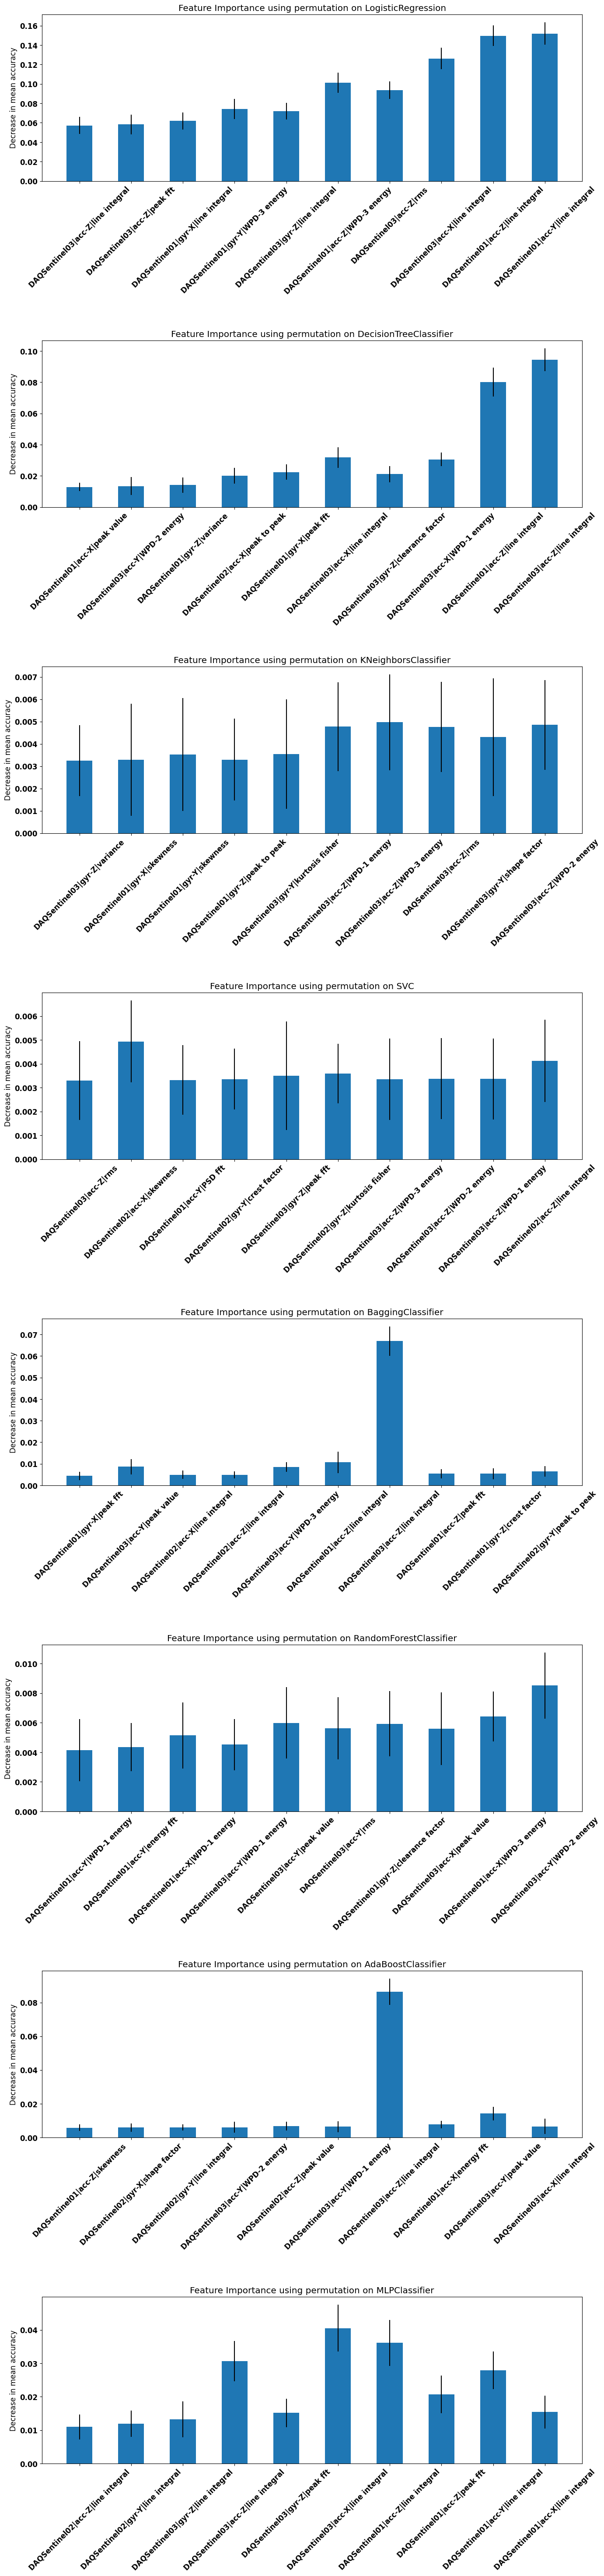

In [23]:
# Reset fonts
font = {
    "family": "sans-serif",
    "weight": "bold",
    "size": 12
}
matplotlib.rc("font", **font)

# Plotting
fig = plt.figure(figsize=(15, 60))
axs = fig.subplots(8, 1)
plot_model_names = list(importances_mean.keys())
index = 0

# Subplots
for row in range(8):

    axs[row].bar(selected_names[plot_model_names[index]], selected_importances_mean[plot_model_names[index]], width=0.5,  yerr=selected_importances_std[plot_model_names[index]])
    axs[row].set_xticks(range(len(selected_names[plot_model_names[index]])))
    axs[row].set_xticklabels(selected_names[plot_model_names[index]], rotation=45)

    # Set labels etc
    axs[row].set_title(f"Feature Importance using permutation on {plot_model_names[index]}")
    axs[row].set_ylabel("Decrease in mean accuracy")

    index = index + 1

# For some spacing
fig.tight_layout(pad=4.0)

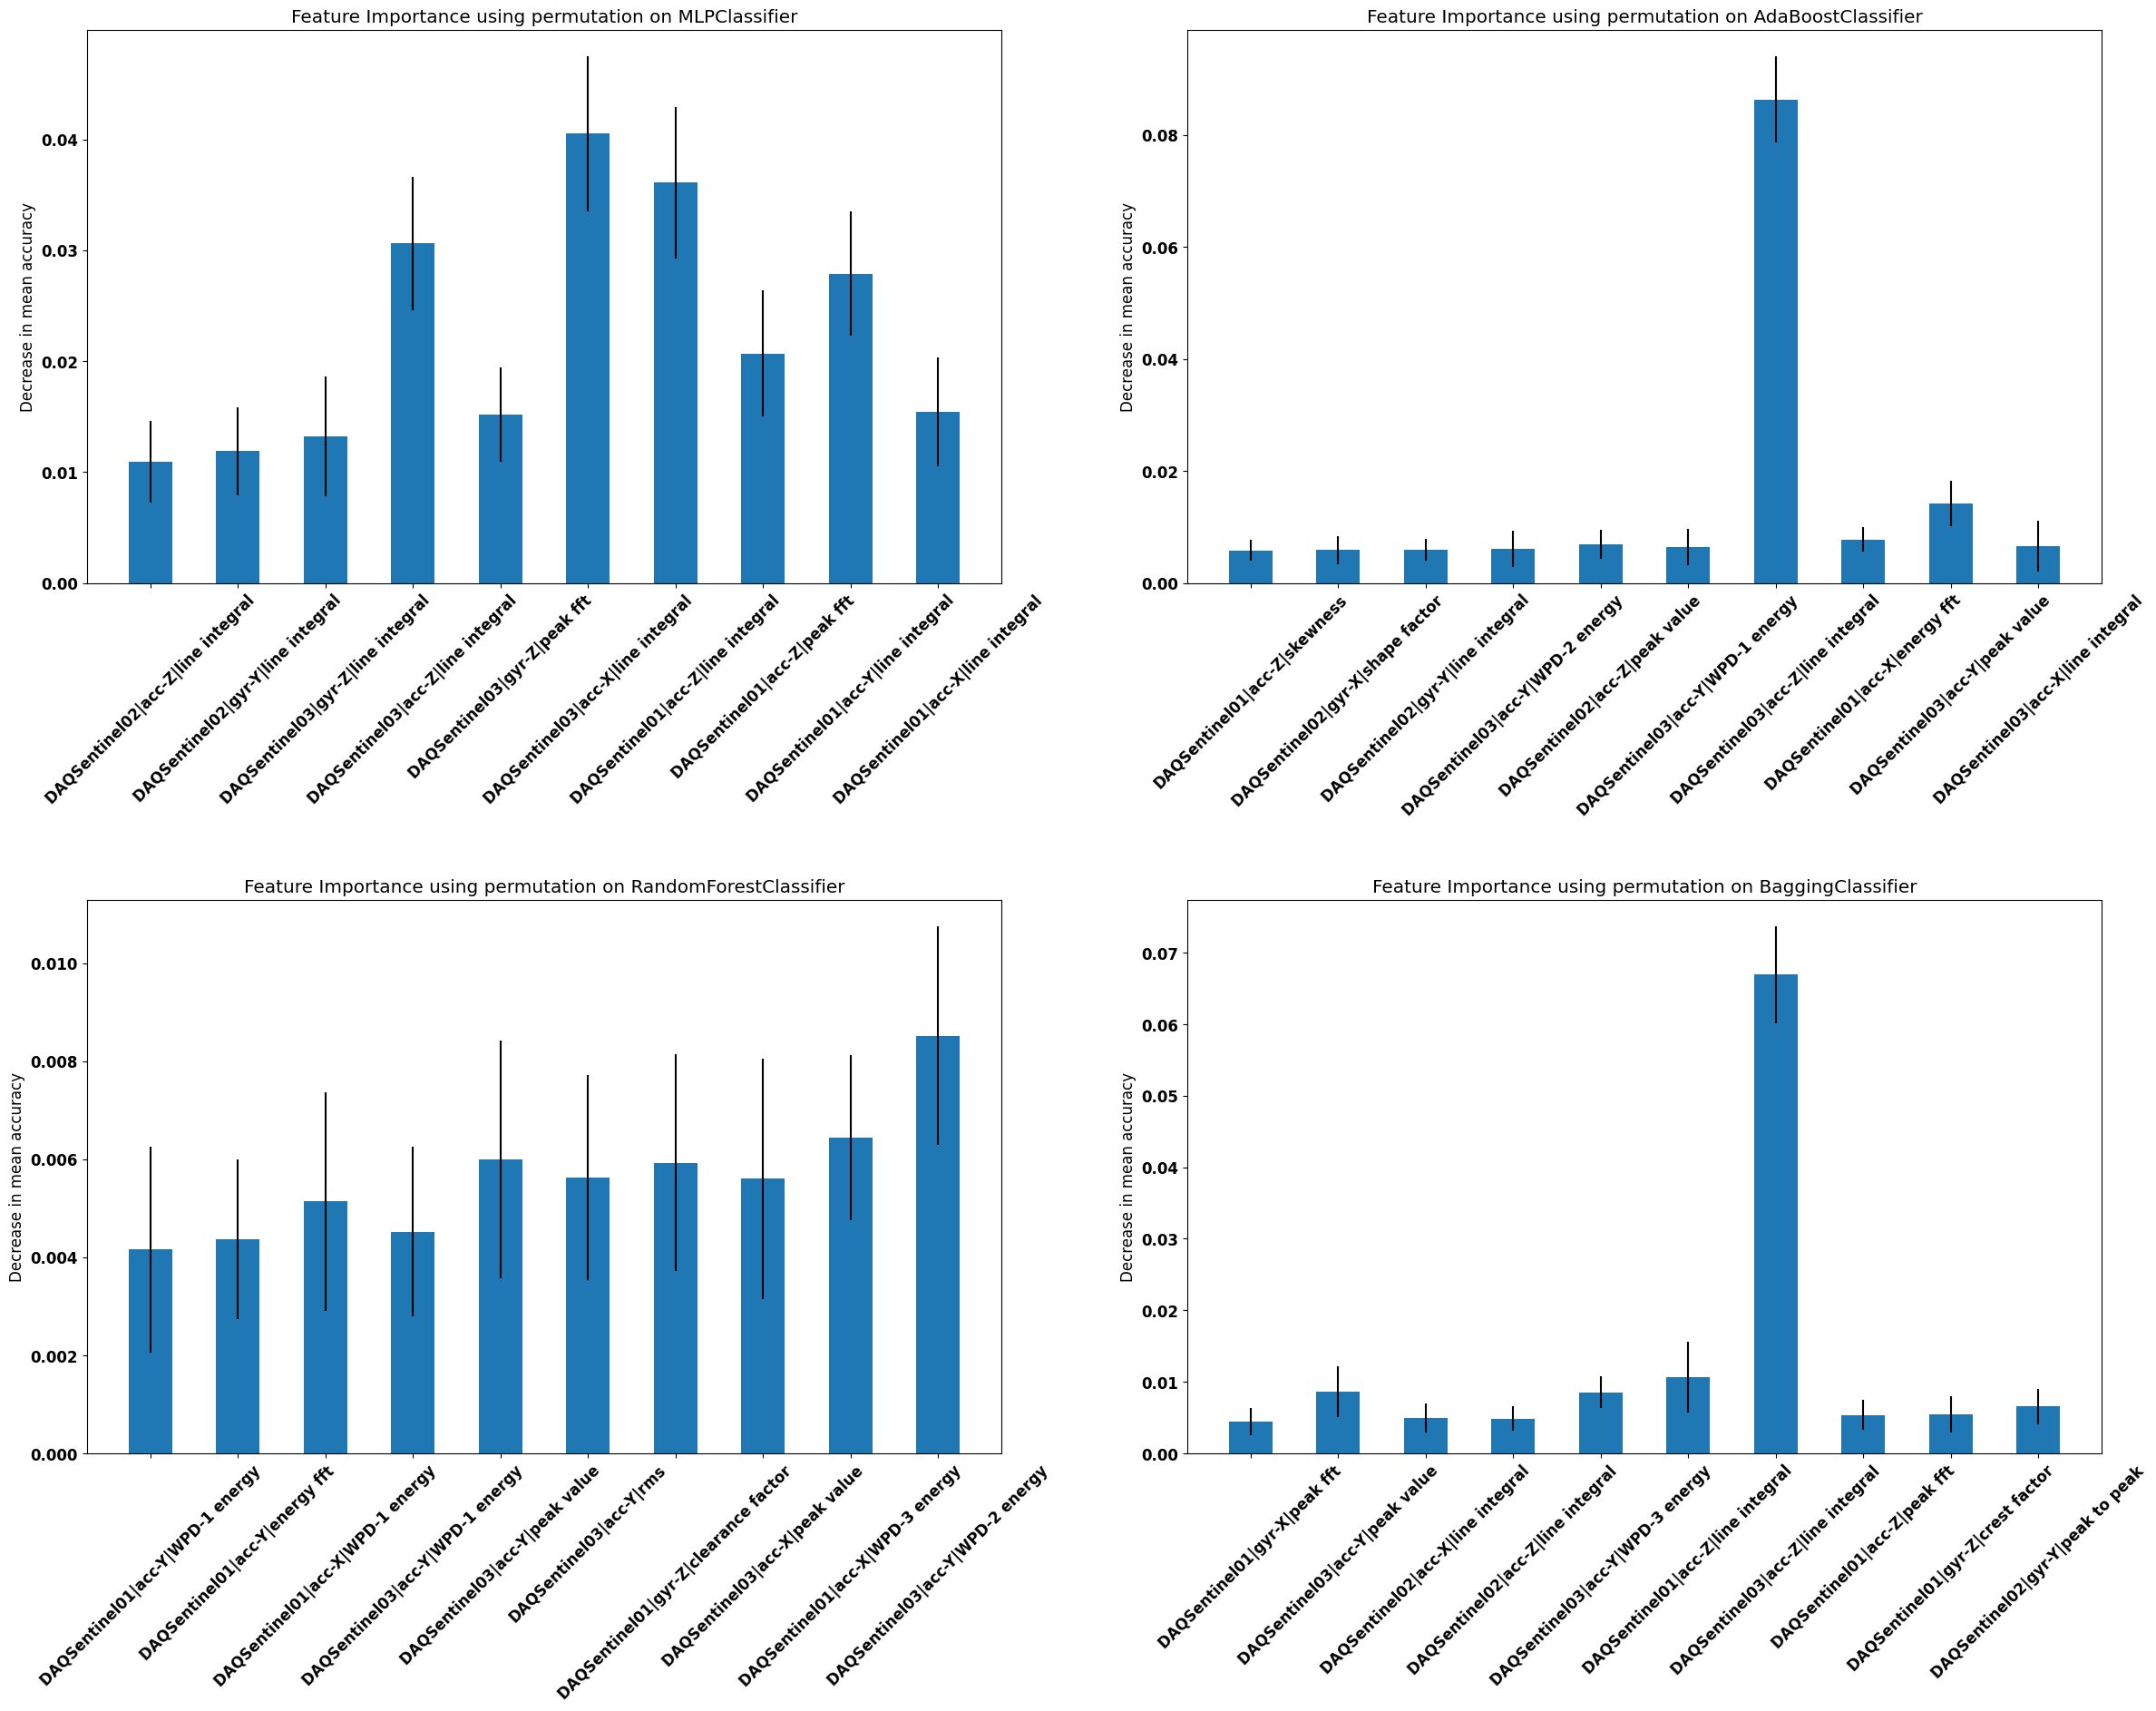

In [32]:
# Reset fonts
font = {
    "family": "sans-serif",
    "weight": "bold",
    "size": 12
}
matplotlib.rc("font", **font)

# Plotting
fig = plt.figure(figsize=(25, 20))
axs = fig.subplots(2, 2)
index = 0

# Subplots
# Only top four models
for row in range(2):
    for col in range(2):
        axs[row, col].bar(selected_names[top_f1score_models[index]], selected_importances_mean[top_f1score_models[index]], width=0.5,  yerr=selected_importances_std[top_f1score_models[index]])
        axs[row, col].set_xticks(range(len(selected_names[top_f1score_models[index]])))
        axs[row, col].set_xticklabels(selected_names[top_f1score_models[index]], rotation=45)
    
        # Set labels etc
        axs[row, col].set_title(f"Feature Importance using permutation on {top_f1score_models[index]}")
        axs[row, col].set_ylabel("Decrease in mean accuracy")
    
        index = index + 1

# For some spacing
fig.tight_layout(pad=4.0)
fig.savefig(os.path.join(fig_save_paths["save_paths"]["feature_imp"], "topkFeatures.png"), dpi=600)

## Identifying the top contributors

- Which sensor is the most important?
- Which type of sensor data was important?

In [25]:
k = 20
model_names = list(importances_mean.keys())
sensor_location_features = []
sensor_features = []
extracted_features = []
for model_name in importances_mean.keys():

    # Get the maximum-k for each model
    maxk_influences_indices = np.argpartition(importances_mean[model_name], -k)[-k:]
    # Get the features
    maxk_feature_names = np.array(feature_names)[maxk_influences_indices]

    # Split the maxk feature names
    for feature_name in maxk_feature_names:
        splits = feature_name.split("|")
        sensor_location_features.append(splits[0].strip())
        sensor_features.append(splits[1].strip())
        extracted_features.append(splits[2].strip())

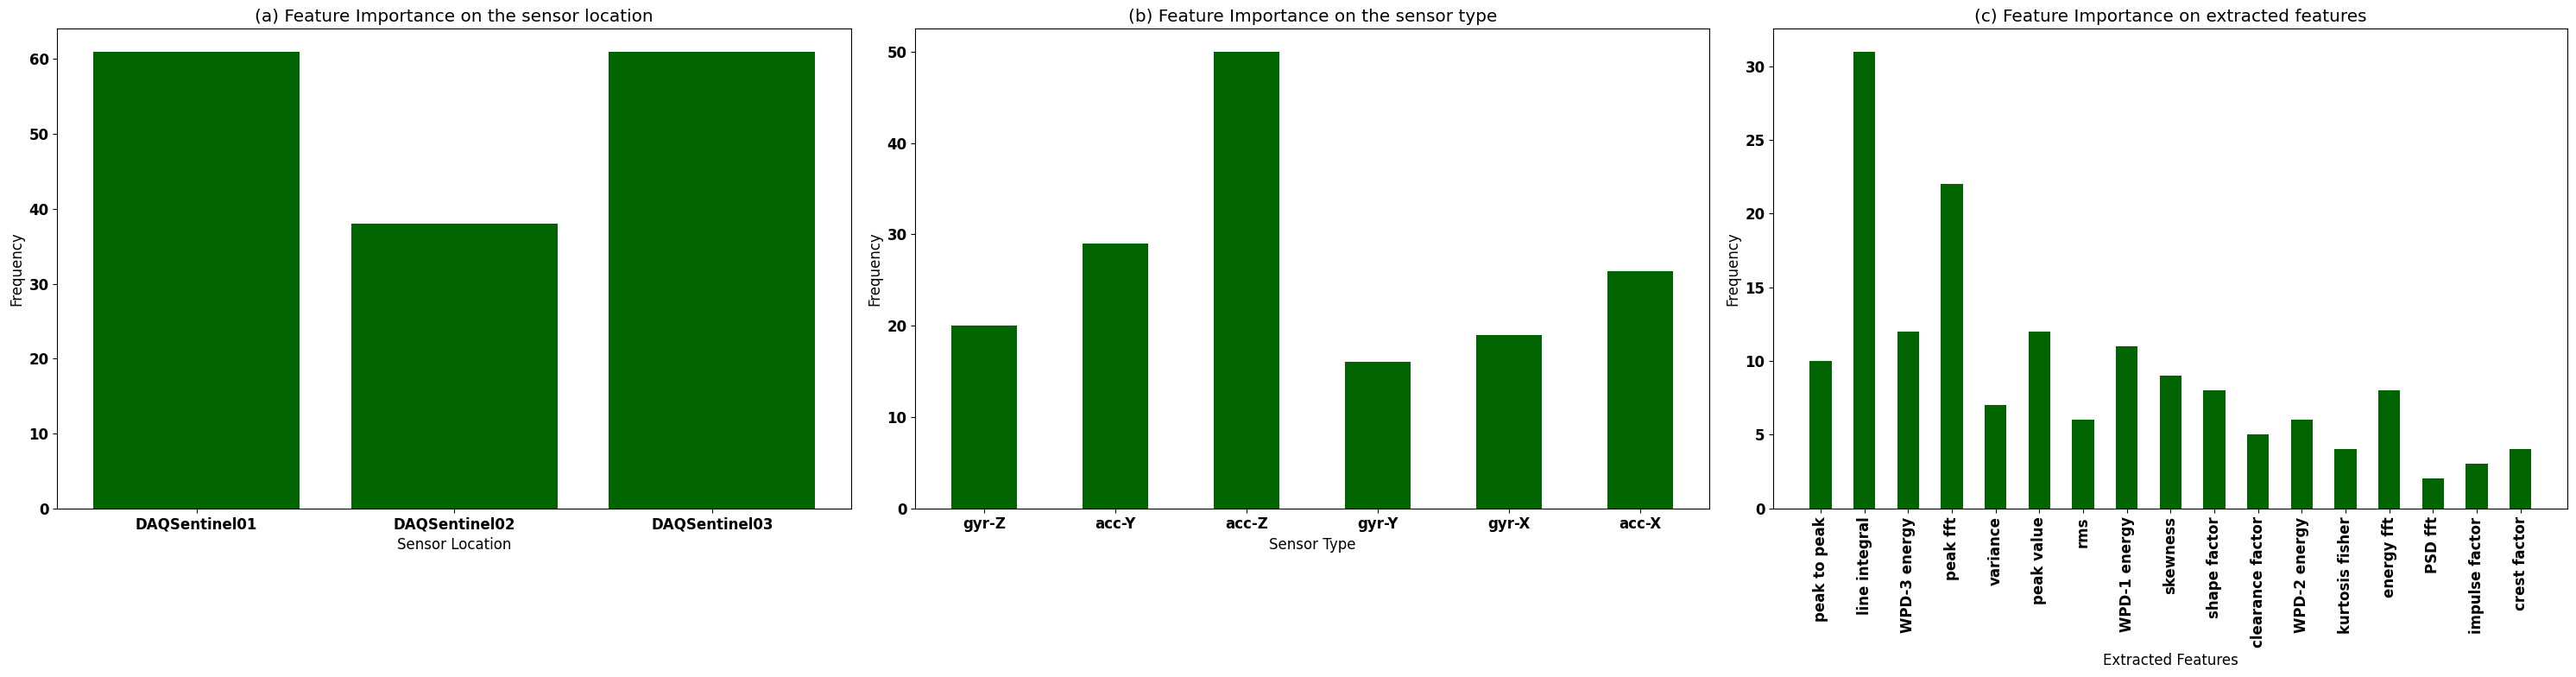

In [33]:
# Count the common contributors
counted_sensor_location_features = Counter(sensor_location_features)
counted_sensor_type_features = Counter(sensor_features)
counted_extracted_features = Counter(extracted_features)

# histogram on the counts
fig = plt.figure(figsize=(30, 8))
axs = fig.subplots(1, 3)
axs[0].bar(counted_sensor_location_features.keys(), counted_sensor_location_features.values(), width=0.8, color="darkgreen")
axs[1].bar(counted_sensor_type_features.keys(), counted_sensor_type_features.values(), width=0.5, color="darkgreen")
axs[2].bar(counted_extracted_features.keys(), counted_extracted_features.values(), width=0.5, color="darkgreen")
# axs[1].set_xticklabels(counted_extracted_features.keys(), rotation=90)
axs[2].set_xticks(list(range(len(counted_extracted_features.keys()))))
axs[2].set_xticklabels(counted_extracted_features.keys(), rotation=90)

# Labels
axs[0].set_xlabel("Sensor Location")
axs[0].set_ylabel("Frequency")
axs[0].set_title("(a) Feature Importance on the sensor location")

axs[1].set_xlabel("Sensor Type")
axs[1].set_ylabel("Frequency")
axs[1].set_title("(b) Feature Importance on the sensor type")

axs[2].set_xlabel("Extracted Features")
axs[2].set_ylabel("Frequency")
axs[2].set_title("(c) Feature Importance on extracted features")

fig.tight_layout()
fig.savefig(os.path.join(fig_save_paths["save_paths"]["feature_imp"], "top_contributors.png"), dpi=600)